# Day 3 Solutions

In [63]:
#loading the required packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from astropy.cosmology import FlatLambdaCDM
import glob


In [74]:
def get_xyz(ra, dec):
    ra = ra*np.pi/180.
    dec = dec*np.pi/180.
    x = np.cos(dec)*np.cos(ra)
    y = np.cos(dec)*np.sin(ra)
    z = np.sin(dec) 
    return x, y, z


In [75]:
print(get_xyz(30,60))

(0.43301270189221946, 0.25, 0.8660254037844386)


In [64]:
# selection cut on the lens sample
def lens_select(zmin=0.1, zmax=0.33, lammin=55, lammax=100):
    #please check the file path properly 
    data = pd.read_csv('/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/redmapper.dat', delim_whitespace=1)
    #sample selection cut
    idx  = (data['lambda']>lammin) & (data['lambda']<=lammax)
    idx  = idx & (data['zred']>zmin) & (data['zred']<=zmax)
    ra   = data['ra'].values[idx]
    dec  = data['dec'].values[idx]
    zred = data['zred'].values[idx]
    #as we have no weights to apply we set them to unity
    wgt  = ra*1.0/ra
    print('number of lenses=%d'%len(ra))
    return ra, dec, zred, wgt


In [78]:
x,y,z,c = lens_select()
np.mean(z)

number of lenses=560


0.24233999447142857

In [65]:
# sanity cheaks on the source files
def read_sources(ifil):
    # various columns in sources 
    # ragal, decgal, e1gal, e2gal, wgal, rms_egal, mgal, c1gal, c2gal, R2gal, zphotgal
    data = pd.read_csv(ifil, delim_whitespace=1).values
    zphotgal = data[:,-1]
    # sanity checks on the sources data
    idx = (np.sum(np.isnan(data), axis=1)==0) &  (zphotgal>0)
    datagal = np.zeros((np.sum(idx),7))
    datagal[:,:6] = data[idx,:6]
    datagal[:,6]  = data[idx,-1]
    # collects only -  ragal, decgal, e1gal, e2gal, wgal, rms_egal, zphotgal
    return datagal

In [66]:
# following surhud's lectures
def get_et(lra, ldec, sra, sdec, se1, se2):
    lra  = lra*np.pi/180
    ldec = ldec*np.pi/180
    sra  = sra*np.pi/180
    sdec = sdec*np.pi/180

    c_theta = np.cos(ldec)*np.cos(sdec)*np.cos(lra - sra) + np.sin(ldec)*np.sin(sdec)
    s_theta = np.sqrt(1-c_theta**2)

    # phi to get the compute the tangential shear
    c_phi   = np.cos(ldec)*np.sin(sra - lra)*1.0/s_theta
    s_phi   = (-np.sin(ldec)*np.cos(sdec) + np.cos(ldec)*np.cos(sra - lra)*np.sin(sdec))*1.0/s_theta
    # tangential shear
    e_t     = - se1*(2*c_phi**2 -1) - se2*(2*c_phi * s_phi)

    return e_t

In [67]:
print(get_et(lra=0, ldec=0, sra=0.123, sdec=0.045, se1 = 4.5e-2, se2 = 1.7e-2))

-0.04534629189830734


In [70]:
def get_sigma_crit_inv(lzred, szred, cc):
    # some important constants for the sigma crit computations
    gee = 4.301e-9 #km^2 Mpc M_sun^-1 s^-2 gravitational constant
    cee = 3e5 #km s^-1
    # sigma_crit_calculations for a given lense-source pair
    sigm_crit_inv = cc.angular_diameter_distance(lzred).value * cc.angular_diameter_distance_z1z2(lzred, szred).value * (1.0 + lzred)**2 * 1.0/cc.angular_diameter_distance(szred).value
    sigm_crit_inv = sigm_crit_inv * 4*np.pi*gee*1.0/cee**2 
    sigm_crit_inv = 1e12*sigm_crit_inv #esd's are in pc not in Mpc

    return sigm_crit_inv

In [71]:
from astropy.cosmology import FlatLambdaCDM
cc = FlatLambdaCDM(H0=100, Om0=0.999)
print(get_sigma_crit_inv(lzred=0.33, szred=0.8, cc=cc))

0.00030436585298495184


In [58]:
outputfile = '/home/idies/workspace/Temporary/divyar/scratch/iagrg_dsigma.dat'

def run_pipe(Omegam=0.315, rmin=0.2, rmax=2.0, nbins=10, zdiff=0.4, outputfile = outputfile):
    #set the cosmology with omegaM parameter 
    cc = FlatLambdaCDM(H0=100, Om0=Omegam) # fixing H0=100 to set units in Mpc h-1
    
    # set the projected radial binning 
    rmin  =  rmin
    rmax  =  rmax
    nbins = nbins #10 radial bins for our case
    rbins  = np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1)
    rdiff  = np.log10(rbins[1]*1.0/rbins[0])
 
    # initializing arrays for signal compuations
    sumdsig_num   = np.zeros(len(rbins[:-1]))
    sumdsigsq_num = np.zeros(len(rbins[:-1]))
    sumwls        = np.zeros(len(rbins[:-1]))
    sumwls_resp   = np.zeros(len(rbins[:-1]))

    # getting the lenses data
    lra, ldec, lred, lwgt = lens_select(zmin=0.1, zmax=0.33, lammin=55, lammax=100)

    # convert lense ra and dec into x,y,z cartesian coordinates
    lx, ly, lz = get_xyz(lra, ldec)
     
    # putting kd tree around the lenses
    lens_tree = cKDTree(np.array([lx, ly, lz]).T)
    
    
    print('lenses tree is ready\n')
    
    # setting maximum search radius
    dcommin = cc.comoving_distance(np.min(lred)).value
    dismax  = (rmax*1.0/(dcommin)) 

    # lets first catch the file list for sources
    sflist = np.sort(glob.glob('/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/*.dat'))

    # Ready to pounce on the source data
    for ifil in sflist:
        # catching the source data matrix
        # please have a check for the columns names
        datagal = read_sources(ifil)
        Ngal = len(datagal[:,0])  # total number of galaxies in the source file
        # first two entries are ra and dec for the sources
        allragal  = datagal[:,0]
        alldecgal = datagal[:,1]
        # ra and dec to x,y,z for sources
        allsx, allsy, allsz = get_xyz(allragal, alldecgal)
        # query in a ball around individual sources and collect the lenses ids with a maximum radius
        slidx = lens_tree.query_ball_point(np.transpose([allsx, allsy, allsz]), dismax) 
        # various columns in sources 
        # ragal, decgal, e1gal, e2gal, wgal, rms_egal, mgal, c1gal, c2gal, R2gal, zphotgal
        # looping over all the galaxies
        for igal in range(Ngal):    
            ragal    = datagal[igal,0]
            decgal   = datagal[igal,1]
            e1gal    = datagal[igal,2]
            e2gal    = datagal[igal,3]
            wgal     = datagal[igal,4]
            rms_egal = datagal[igal,5]
            zphotgal = datagal[igal,6]
           
            # array of lenses indices
            lidx = np.array(slidx[igal])
            # removing sources which doesn't have any lenses around them 
            if len(lidx)==0:
                continue
           
            # selecting a cleaner background
            zcut = (lred[lidx] < (zphotgal - zdiff)) #only taking the foreground lenses
            # again skipping the onces which doesn't satisfy the above criteria
            if np.sum(zcut)==0.0:
                continue
            # collecting the  data of lenses around individual source
            lidx   = lidx[zcut] # this will catch the array indices for our lenses
            sra    = ragal
            sdec   = decgal
            
            l_ra   = lra[lidx]
            l_dec  = ldec[lidx]
            l_zred = lred[lidx] 
            l_wgt  = lwgt[lidx] 
           
            sx, sy, sz = get_xyz(sra,sdec) # individual galaxy ra,dec-->x,y,z
            lx, ly, lz = get_xyz(l_ra,l_dec) # individual galaxy ra,dec-->x,y,z
            
            # getting the radial separations for a lense source pair 
            sl_sep = np.sqrt((lx - sx)**2 + (ly - sy)**2 + (lz - sz)**2)
            sl_sep = sl_sep * cc.comoving_distance(l_zred).value
            for ll,sep in enumerate(sl_sep):
                if sep<rmin or sep>rmax:
                    continue
                rb = int(np.log10(sep*1.0/rmin)*1/rdiff)
               
                # get tangantial components given positions and shapes
                e_t = get_et(lra = l_ra[ll], ldec = l_dec[ll], sra = sra, sdec = sdec, se1 = e1gal,  se2 = e2gal)

                # sigma_crit_calculations for a given lense-source pair
                sigm_crit_inv = get_sigma_crit_inv(l_zred[ll], zphotgal, cc)

                # following equations given in the surhud's lectures 
                w_ls    = l_wgt[ll] * wgal * (sigm_crit_inv)**2
                w_ls_by_av_sigc_inv = l_wgt[ll] * wgal * sigm_crit_inv

                # separate numerator and denominator computation   
                sumdsig_num[rb]   += w_ls_by_av_sigc_inv  * e_t
                sumdsigsq_num[rb] += (w_ls_by_av_sigc_inv * e_t)**2
                sumwls[rb]        += w_ls
                sumwls_resp[rb]   += w_ls * (1-rms_egal**2)

        print(ifil)
        
      
    fout = open(outputfile, "w")
    fout.write("# 0:rmin/2+rmax/2 1:DeltaSigma 2:SN_ErrDeltaSigma\n")
    for i in range(len(rbins[:-1])):
        rrmin = rbins[i]
        rrmax = rbins[i+1]
        Resp = sumwls_resp[i]*1.0/sumwls[i]
        
        fout.write("%le\t%le\t%le\n"%(rrmin/2.0+rrmax/2.0, sumdsig_num[i]*1.0/sumwls[i]/2./Resp, np.sqrt(sumdsigsq_num[i])*1.0/sumwls[i]/2./Resp))
    fout.write("#OK")    
    fout.close()
    
    return 0

In [61]:
run_pipe()

number of lenses=560
lenses tree is ready

/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0000.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0001.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0002.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0003.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0004.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0005.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0006.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0007.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0008.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0009.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0010.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0011.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0012.dat
/home/idies/workspace/Storage/divy

/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0115.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0116.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0117.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0118.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0119.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0120.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0121.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0122.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0123.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0124.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0125.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0126.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0127.dat
/home/idies/workspace/Storage/divyar/IAGRG_2022/DataStore/hsc/0128.dat
/home/

0

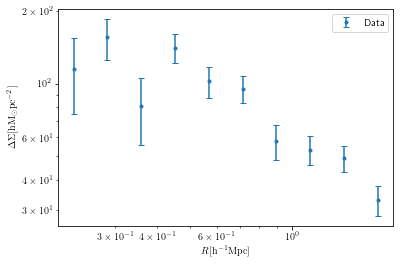

In [62]:
dat = np.loadtxt('iagrg_dsigma.dat')

plt.errorbar(dat[:,0], dat[:,1], yerr=dat[:,2], fmt='.', capsize=3, label='Data')
plt.legend()

plt.xlabel(r'$R[{\rm h^{-1}Mpc}]$')
plt.ylabel(r'$\Delta\Sigma [{\rm h M_\odot pc^{-2}}]$')
plt.xscale('log')
plt.yscale('log')